In [81]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import *
from collections import Counter
import pickle as pkl
import gradio as gr

# ========== LOAD DATA ==========

In [82]:
fpaData = pd.read_csv("FloodDataRecentry.csv")
fpaData

,record_id,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1,8/15/2018,Long Dry Season,lowland,True,False,False,True,True,0.0,0.43,24.4,27.8,51.3,9.5,1021.6,0.371,0,-2.133698,29.080604
1,2,2/17/2023,Short Dry Season,lowland,True,False,False,True,True,0.0,0.59,32.5,23.0,63.5,9.9,1013.6,0.425,0,-2.728152,29.250768
2,3,8/6/2015,Long Dry Season,upland,True,False,False,True,False,0.1,0.57,36.7,22.6,52.6,9.1,1010.6,0.277,0,-1.050747,30.633270
3,4,7/24/2024,Long Dry Season,upland,False,False,True,False,True,0.1,0.57,29.5,24.7,48.9,9.4,1014.7,0.060,0,-1.253076,30.566618
4,5,7/21/2020,Long Dry Season,upland,True,True,True,True,False,0.1,0.46,24.2,27.9,39.4,9.4,1011.7,0.341,0,-1.264124,30.362866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85867,85868,9/16/2019,Short Rainy Season,lowland,True,True,False,True,True,158.8,3.44,100.0,22.4,100.0,13.6,1007.3,0.990,1,-2.164245,28.995178
85868,85869,11/30/2021,Short Rainy Season,lowland,False,True,False,True,True,160.6,3.50,100.0,23.9,100.0,9.7,1012.0,0.990,1,-2.539320,28.963445
85869,85870,11/9/2015,Short Rainy Season,lowland,True,False,False,False,True,161.8,3.50,100.0,18.7,100.0,12.4,1008.6,0.990,1,-2.427609,29.209905
85870,85871,9/11/2015,Short Rainy Season,lowland,True,False,True,True,True,164.1,3.50,100.0,19.7,100.0,5.9,1021.3,0.990,1,-2.886268,29.061142


In [83]:
print(fpaData.columns.tolist())

['record_id', 'date', 'season', 'location_type', 'has_river', 'has_lake', 'has_poor_drainage', 'is_urban', 'is_deforested', 'rainfall_mm', 'water_level_m', 'soil_moisture', 'temp_c', 'humidity', 'wind_speed', 'pressure', 'flood_probability', 'flood', 'latitude', 'longitude']


In [84]:
fpaData.isnull().sum()


record_id            0
date                 0
season               0
location_type        0
has_river            0
has_lake             0
has_poor_drainage    0
is_urban             0
is_deforested        0
rainfall_mm          0
water_level_m        0
soil_moisture        0
temp_c               0
humidity             0
wind_speed           0
pressure             0
flood_probability    0
flood                0
latitude             0
longitude            0
dtype: int64

In [85]:
# Impute using group mean (season + location_type)
fpaData['rainfall_mm'] = fpaData.groupby(['season', 'location_type'])['rainfall_mm'].transform(
    lambda x: x.fillna(x.mean())
)

# Fill remaining missing (if any group was all NaN)
fpaData['rainfall_mm'] = fpaData['rainfall_mm'].fillna(fpaData['rainfall_mm'].mean())


In [86]:
fpaData

,record_id,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1,8/15/2018,Long Dry Season,lowland,True,False,False,True,True,0.0,0.43,24.4,27.8,51.3,9.5,1021.6,0.371,0,-2.133698,29.080604
1,2,2/17/2023,Short Dry Season,lowland,True,False,False,True,True,0.0,0.59,32.5,23.0,63.5,9.9,1013.6,0.425,0,-2.728152,29.250768
2,3,8/6/2015,Long Dry Season,upland,True,False,False,True,False,0.1,0.57,36.7,22.6,52.6,9.1,1010.6,0.277,0,-1.050747,30.633270
3,4,7/24/2024,Long Dry Season,upland,False,False,True,False,True,0.1,0.57,29.5,24.7,48.9,9.4,1014.7,0.060,0,-1.253076,30.566618
4,5,7/21/2020,Long Dry Season,upland,True,True,True,True,False,0.1,0.46,24.2,27.9,39.4,9.4,1011.7,0.341,0,-1.264124,30.362866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85867,85868,9/16/2019,Short Rainy Season,lowland,True,True,False,True,True,158.8,3.44,100.0,22.4,100.0,13.6,1007.3,0.990,1,-2.164245,28.995178
85868,85869,11/30/2021,Short Rainy Season,lowland,False,True,False,True,True,160.6,3.50,100.0,23.9,100.0,9.7,1012.0,0.990,1,-2.539320,28.963445
85869,85870,11/9/2015,Short Rainy Season,lowland,True,False,False,False,True,161.8,3.50,100.0,18.7,100.0,12.4,1008.6,0.990,1,-2.427609,29.209905
85870,85871,9/11/2015,Short Rainy Season,lowland,True,False,True,True,True,164.1,3.50,100.0,19.7,100.0,5.9,1021.3,0.990,1,-2.886268,29.061142


# ========== ENCODE season and location_type AS INTEGERS ==========

In [87]:
# Define helper functions to clean strings safely (skip non-strings)
def clean_season(val):
    if isinstance(val, str):
        return val.strip().title()
    else:
        return None  # or pd.NA

def clean_location(val):
    if isinstance(val, str):
        return val.strip().lower()
    else:
        return None  # or pd.NA

fpaData['season'] = fpaData['season'].apply(clean_season)
fpaData['location_type'] = fpaData['location_type'].apply(clean_location)

print("\nCleaned Data:")
print(fpaData)



Cleaned Data:
       record_id        date              season location_type  has_river  \
0              1   8/15/2018     Long Dry Season       lowland       True   
1              2   2/17/2023    Short Dry Season       lowland       True   
2              3    8/6/2015     Long Dry Season        upland       True   
3              4   7/24/2024     Long Dry Season        upland      False   
4              5   7/21/2020     Long Dry Season        upland       True   
...          ...         ...                 ...           ...        ...   
85867      85868   9/16/2019  Short Rainy Season       lowland       True   
85868      85869  11/30/2021  Short Rainy Season       lowland      False   
85869      85870   11/9/2015  Short Rainy Season       lowland       True   
85870      85871   9/11/2015  Short Rainy Season       lowland       True   
85871      85872    4/2/2021   Long Rainy Season       lowland      False   

       has_lake  has_poor_drainage  is_urban  is_deforested 

In [88]:
# 2. Encode season and location_type
season_mapping = {
    "Long Rainy Season": 1,
    "Short Rainy Season": 2,
    "Long Dry Season": 3,
    "Short Dry Season": 4
}
location_mapping = {
    "lowland": 1,
    "middleland": 2,
    "upland": 3
}

fpaData['season'] = fpaData['season'].map(season_mapping)
fpaData['location_type'] = fpaData['location_type'].map(location_mapping)
# ✅ Validate mappings
if fpaData['season'].isnull().any():
    print("⚠️ Some season values failed to map!")

if fpaData['location_type'].isnull().any():
    print("⚠️ Some location_type values failed to map!")
fpaData

,record_id,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1,8/15/2018,3,1,True,False,False,True,True,0.0,0.43,24.4,27.8,51.3,9.5,1021.6,0.371,0,-2.133698,29.080604
1,2,2/17/2023,4,1,True,False,False,True,True,0.0,0.59,32.5,23.0,63.5,9.9,1013.6,0.425,0,-2.728152,29.250768
2,3,8/6/2015,3,3,True,False,False,True,False,0.1,0.57,36.7,22.6,52.6,9.1,1010.6,0.277,0,-1.050747,30.633270
3,4,7/24/2024,3,3,False,False,True,False,True,0.1,0.57,29.5,24.7,48.9,9.4,1014.7,0.060,0,-1.253076,30.566618
4,5,7/21/2020,3,3,True,True,True,True,False,0.1,0.46,24.2,27.9,39.4,9.4,1011.7,0.341,0,-1.264124,30.362866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85867,85868,9/16/2019,2,1,True,True,False,True,True,158.8,3.44,100.0,22.4,100.0,13.6,1007.3,0.990,1,-2.164245,28.995178
85868,85869,11/30/2021,2,1,False,True,False,True,True,160.6,3.50,100.0,23.9,100.0,9.7,1012.0,0.990,1,-2.539320,28.963445
85869,85870,11/9/2015,2,1,True,False,False,False,True,161.8,3.50,100.0,18.7,100.0,12.4,1008.6,0.990,1,-2.427609,29.209905
85870,85871,9/11/2015,2,1,True,False,True,True,True,164.1,3.50,100.0,19.7,100.0,5.9,1021.3,0.990,1,-2.886268,29.061142


In [89]:
fpaData

,record_id,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1,8/15/2018,3,1,True,False,False,True,True,0.0,0.43,24.4,27.8,51.3,9.5,1021.6,0.371,0,-2.133698,29.080604
1,2,2/17/2023,4,1,True,False,False,True,True,0.0,0.59,32.5,23.0,63.5,9.9,1013.6,0.425,0,-2.728152,29.250768
2,3,8/6/2015,3,3,True,False,False,True,False,0.1,0.57,36.7,22.6,52.6,9.1,1010.6,0.277,0,-1.050747,30.633270
3,4,7/24/2024,3,3,False,False,True,False,True,0.1,0.57,29.5,24.7,48.9,9.4,1014.7,0.060,0,-1.253076,30.566618
4,5,7/21/2020,3,3,True,True,True,True,False,0.1,0.46,24.2,27.9,39.4,9.4,1011.7,0.341,0,-1.264124,30.362866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85867,85868,9/16/2019,2,1,True,True,False,True,True,158.8,3.44,100.0,22.4,100.0,13.6,1007.3,0.990,1,-2.164245,28.995178
85868,85869,11/30/2021,2,1,False,True,False,True,True,160.6,3.50,100.0,23.9,100.0,9.7,1012.0,0.990,1,-2.539320,28.963445
85869,85870,11/9/2015,2,1,True,False,False,False,True,161.8,3.50,100.0,18.7,100.0,12.4,1008.6,0.990,1,-2.427609,29.209905
85870,85871,9/11/2015,2,1,True,False,True,True,True,164.1,3.50,100.0,19.7,100.0,5.9,1021.3,0.990,1,-2.886268,29.061142


In [90]:
fpaData

,record_id,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1,8/15/2018,3,1,True,False,False,True,True,0.0,0.43,24.4,27.8,51.3,9.5,1021.6,0.371,0,-2.133698,29.080604
1,2,2/17/2023,4,1,True,False,False,True,True,0.0,0.59,32.5,23.0,63.5,9.9,1013.6,0.425,0,-2.728152,29.250768
2,3,8/6/2015,3,3,True,False,False,True,False,0.1,0.57,36.7,22.6,52.6,9.1,1010.6,0.277,0,-1.050747,30.633270
3,4,7/24/2024,3,3,False,False,True,False,True,0.1,0.57,29.5,24.7,48.9,9.4,1014.7,0.060,0,-1.253076,30.566618
4,5,7/21/2020,3,3,True,True,True,True,False,0.1,0.46,24.2,27.9,39.4,9.4,1011.7,0.341,0,-1.264124,30.362866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85867,85868,9/16/2019,2,1,True,True,False,True,True,158.8,3.44,100.0,22.4,100.0,13.6,1007.3,0.990,1,-2.164245,28.995178
85868,85869,11/30/2021,2,1,False,True,False,True,True,160.6,3.50,100.0,23.9,100.0,9.7,1012.0,0.990,1,-2.539320,28.963445
85869,85870,11/9/2015,2,1,True,False,False,False,True,161.8,3.50,100.0,18.7,100.0,12.4,1008.6,0.990,1,-2.427609,29.209905
85870,85871,9/11/2015,2,1,True,False,True,True,True,164.1,3.50,100.0,19.7,100.0,5.9,1021.3,0.990,1,-2.886268,29.061142


In [91]:
# 3. Convert boolean features to integers
bool_cols = ['has_river', 'has_lake', 'has_poor_drainage', 'is_urban', 'is_deforested']
for col in bool_cols:
    fpaData[col] = fpaData[col].astype(int)

fpaData

,record_id,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1,8/15/2018,3,1,1,0,0,1,1,0.0,0.43,24.4,27.8,51.3,9.5,1021.6,0.371,0,-2.133698,29.080604
1,2,2/17/2023,4,1,1,0,0,1,1,0.0,0.59,32.5,23.0,63.5,9.9,1013.6,0.425,0,-2.728152,29.250768
2,3,8/6/2015,3,3,1,0,0,1,0,0.1,0.57,36.7,22.6,52.6,9.1,1010.6,0.277,0,-1.050747,30.633270
3,4,7/24/2024,3,3,0,0,1,0,1,0.1,0.57,29.5,24.7,48.9,9.4,1014.7,0.060,0,-1.253076,30.566618
4,5,7/21/2020,3,3,1,1,1,1,0,0.1,0.46,24.2,27.9,39.4,9.4,1011.7,0.341,0,-1.264124,30.362866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85867,85868,9/16/2019,2,1,1,1,0,1,1,158.8,3.44,100.0,22.4,100.0,13.6,1007.3,0.990,1,-2.164245,28.995178
85868,85869,11/30/2021,2,1,0,1,0,1,1,160.6,3.50,100.0,23.9,100.0,9.7,1012.0,0.990,1,-2.539320,28.963445
85869,85870,11/9/2015,2,1,1,0,0,0,1,161.8,3.50,100.0,18.7,100.0,12.4,1008.6,0.990,1,-2.427609,29.209905
85870,85871,9/11/2015,2,1,1,0,1,1,1,164.1,3.50,100.0,19.7,100.0,5.9,1021.3,0.990,1,-2.886268,29.061142


# Exploratory Data Analysis

# ========== SELECT FEATURES AND TARGET ==========

In [92]:
# 4. Select features and target
features = [
    'rainfall_mm', 'water_level_m', 'soil_moisture', 'temp_c', 'humidity',
    'wind_speed', 'pressure',
    'has_river', 'has_lake', 'has_poor_drainage', 'is_urban', 'is_deforested',
    'season', 'location_type'
]
target = 'flood'

X = fpaData[features]
y = fpaData[target]

# ========== SPLIT DATA ==========

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# ========== Train models ==========

In [94]:
X_train

,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,season,location_type
3565,2.2,0.40,28.7,19.2,43.9,7.7,1013.1,1,1,0,1,0,3,1
17346,6.1,0.77,40.7,24.5,51.4,17.0,1006.8,1,0,0,0,1,3,3
22496,7.4,0.80,40.4,26.7,64.0,11.2,1015.9,1,1,1,1,0,4,3
22782,7.4,0.53,38.6,23.4,48.3,14.1,1008.1,1,1,0,1,1,2,1
28863,9.1,0.30,35.8,21.7,54.2,11.1,1005.0,0,1,0,1,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,3.1,0.81,30.2,23.4,50.5,8.7,1006.9,1,1,0,0,0,4,1
54886,18.1,0.87,41.8,18.6,55.4,11.8,1019.6,0,1,0,1,1,4,1
76820,36.8,1.24,56.4,20.0,79.0,8.8,1011.5,1,0,0,0,1,1,1
860,1.1,0.53,33.2,23.0,42.3,4.8,1008.5,0,0,1,1,0,3,3


# ==========Initialize models ==========

In [95]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit models
rf_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)


c:\Users\user\anaconda3\envs\my_jupyter_clone\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:13:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

# Store results
evaluation_results = []

# Extended function
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        auc = None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Save results for plotting
    evaluation_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': auc if auc is not None else 0
    })

    print(f"📊 Evaluation for {name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    if auc is not None:
        print("ROC AUC:", auc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)

# Run evaluation
evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(knn_model, X_test, y_test, "KNN")
evaluate_model(xgb_model, X_test, y_test, "XGBoost")


📊 Evaluation for Random Forest
Accuracy: 0.9741484716157205
Precision: 0.9781061850027367
Recall: 0.9734175836147728
F1 Score: 0.9757562520476138
ROC AUC: 0.9949286183019608

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      7996
           1       0.98      0.97      0.98      9179

    accuracy                           0.97     17175
   macro avg       0.97      0.97      0.97     17175
weighted avg       0.97      0.97      0.97     17175

--------------------------------------------------
📊 Evaluation for KNN
Accuracy: 0.7884133915574963
Precision: 0.8190815974220278
Recall: 0.7753567926789411
F1 Score: 0.7966196552496082
ROC AUC: 0.8591410042094803

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78      7996
           1       0.82      0.78      0.80      9179

    accuracy                           0.79     17175
   macro avg    

C:\Users\user\AppData\Local\Temp\ipykernel_4076\1059058900.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_4076\1059058900.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("model_comparison.png")
c:\Users\user\anaconda3\envs\my_jupyter_clone\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


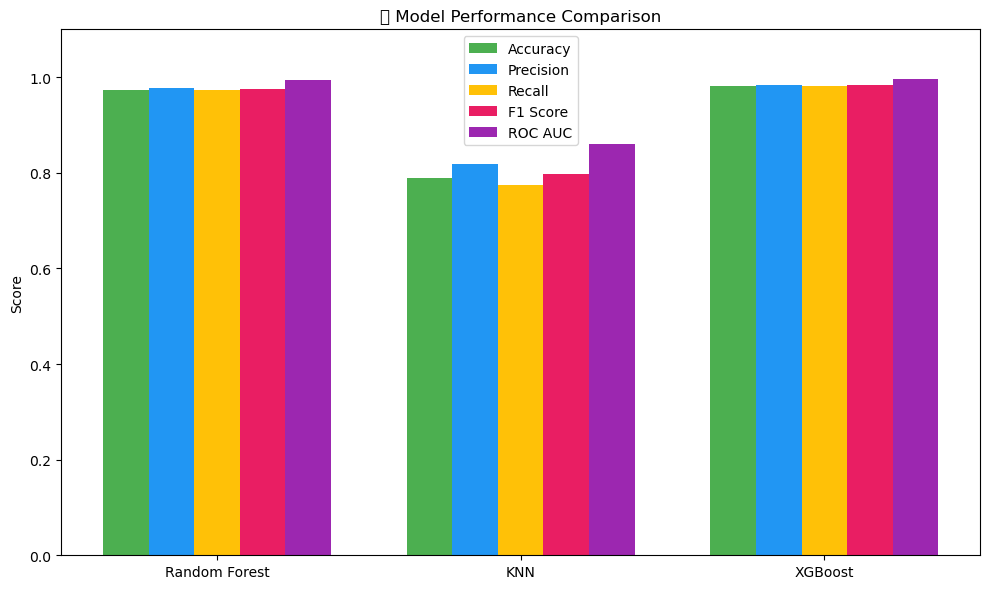

In [97]:
# Convert to DataFrame
results_df = pd.DataFrame(evaluation_results)

# Plot
plt.figure(figsize=(10, 6))
bar_width = 0.15
index = range(len(results_df))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
colors = ['#4CAF50', '#2196F3', '#FFC107', '#E91E63', '#9C27B0']

for i, metric in enumerate(metrics):
    plt.bar(
        [x + i * bar_width for x in index],
        results_df[metric],
        width=bar_width,
        label=metric,
        color=colors[i]
    )

plt.xticks([r + bar_width * 2 for r in index], results_df['Model'])
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.title("📊 Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_4076\2830674049.py:16: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_4076\2830674049.py:17: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("accuracy_comparison.png")
c:\Users\user\anaconda3\envs\my_jupyter_clone\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


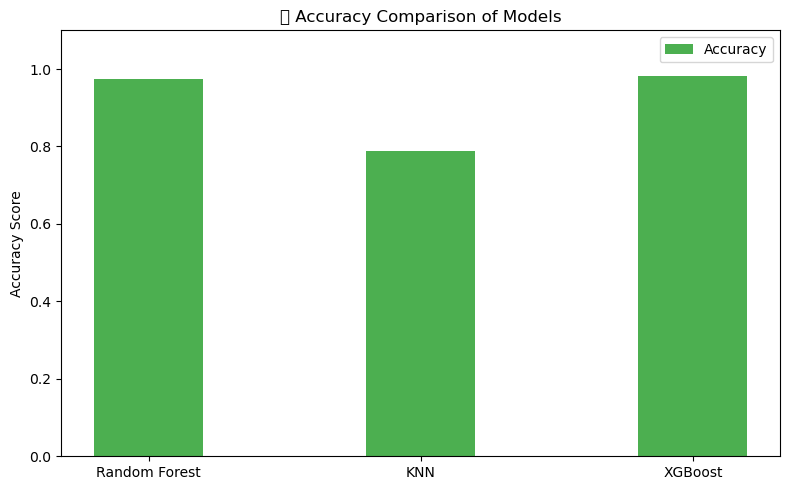

In [98]:
# Convert to DataFrame
results_df = pd.DataFrame(evaluation_results)

# Plot Accuracy Only
plt.figure(figsize=(8, 5))
bar_width = 0.4
index = range(len(results_df))

plt.bar(index, results_df['Accuracy'], width=bar_width, color='#4CAF50', label='Accuracy')

plt.xticks(index, results_df['Model'])
plt.ylabel("Accuracy Score")
plt.ylim(0, 1.1)
plt.title("✅ Accuracy Comparison of Models")
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_comparison.png")
plt.show()


In [99]:
# Save Models
pkl.dump(rf_model, open('randomModel_flood_prediction_model.pkl', 'wb'))
pkl.dump(knn_model, open('kModel_flood_prediction_model.pkl', 'wb'))
pkl.dump(xgb_model, open('xgbModel_flood_prediction_model.pkl', 'wb'))


# ========== Test models ==========

In [100]:

# Load trained models
rf_model = pkl.load(open('randomModel_flood_prediction_model.pkl', 'rb'))
knn_model = pkl.load(open('kModel_flood_prediction_model.pkl', 'rb'))
xgb_model = pkl.load(open('xgbModel_flood_prediction_model.pkl', 'rb'))

# Categorical mappings
season_mapping = {
    "Long Rainy Season": 1,
    "Short Rainy Season": 2,
    "Long Dry Season": 3,
    "Short Dry Season": 4
}
location_mapping = {
    "lowland": 1,
    "middleland": 2,
    "upland": 3
}

# Risk categorization helper
def categorize_risk(prob):
    if prob >= 0.8:
        return "🚨 High Flood Risk"
    elif prob >= 0.5:
        return "⚠️ Medium Flood Risk"
    else:
        return "✅ Low Flood Risk"

# Prediction function
def predict_flood(rainfall, water_level, soil_moisture, temp, humidity,
                  wind_speed, pressure, has_river, has_lake, has_poor_drainage,
                  is_urban, is_deforested, season, location_type, model_choice):

    season_code = season_mapping.get(season, 0)
    location_code = location_mapping.get(location_type, 0)

    input_data = pd.DataFrame([{
        'rainfall_mm': rainfall,
        'water_level_m': water_level,
        'soil_moisture': soil_moisture,
        'temp_c': temp,
        'humidity': humidity,
        'wind_speed': wind_speed,
        'pressure': pressure,
        'has_river': int(has_river),
        'has_lake': int(has_lake),
        'has_poor_drainage': int(has_poor_drainage),
        'is_urban': int(is_urban),
        'is_deforested': int(is_deforested),
        'season': season_code,
        'location_type': location_code
    }])

    # Choose model
    if model_choice == "Random Forest":
        model = rf_model
    elif model_choice == "KNN":
        model = knn_model
    elif model_choice == "XGBoost":
        model = xgb_model
    else:
        return "❌ Invalid Model", "N/A"

    # Predict
    prediction = model.predict(input_data)[0]
    try:
        prob = model.predict_proba(input_data)[0][1]
        prob_str = f"{prob:.4f}"
        risk = categorize_risk(prob)
    except:
        prob_str = "N/A"
        risk = "Risk level unavailable"

    return risk, prob_str


In [101]:
interface = gr.Interface(
    fn=predict_flood,
    inputs=[
        gr.Number(label="Rainfall (mm)"),
        gr.Number(label="Water Level (m)"),
        gr.Number(label="Soil Moisture"),
        gr.Number(label="Temperature (°C)"),
        gr.Number(label="Humidity (%)"),
        gr.Number(label="Wind Speed"),
        gr.Number(label="Pressure"),
        gr.Checkbox(label="Has River"),
        gr.Checkbox(label="Has Lake"),
        gr.Checkbox(label="Has Poor Drainage"),
        gr.Checkbox(label="Is Urban"),
        gr.Checkbox(label="Is Deforested"),
        gr.Radio(choices=list(season_mapping.keys()), label="Season"),
        gr.Radio(choices=list(location_mapping.keys()), label="Location Type"),
        gr.Radio(choices=["Random Forest", "KNN", "XGBoost"], label="Model to Use")
    ],
    outputs=[
        gr.Label(label="Flood Risk Level"),
        gr.Textbox(label="Flood Probability")
    ],
    title="🌊 Flood Risk Prediction App",
    description="Input environmental conditions and choose a model to predict flood risk level and probability."
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.
